First, I import GPy, a Python library for GPR implementations. I also get a function to help me make training data based on test case and variation numbers

In [1]:
import sys
sys.path.append('../../../../../')
from plot_tools.fig_preamble import * # imports numpy, matplotlib, Py2PDF, plot_helper_funcs, plot_figstyle_sheet
import GPy


from gpr.common import get_data, simple_unlearnable_sine
from data_tools.load_raw_cluster_data import LoadExperiment as le
from plot_tools.plot_figstyle_sheet import color_pallete, predmarker, COLOURDICT, STYLEDICT

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


In [2]:
ver=0
datapath = '../../../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig2 = '../svg/paper_v0_'
figdata = '../svg/fig_data/paper_v0_'
figname2 = 'GPR'

We link the periodicity and the lengthscale to the longest and shortest timescales of the system during training.

Namely:
    - p = N_train
    - l = 3 * Delta T 
    
We note that if the optimal periodicity >> N_train or N, the algorithm tends to pick l <<< Delta T, and a failure results.

In [3]:
# Set parameters
n_train = 2000
Delta_T = 0.001
n_predict = 150
n_testbefore=50

In [4]:
# Set initial starting values for L-BFGS-B OPtimiser in GPy
sigma_0 = 1.0
R_0 =  1.0

In [5]:
# Set length scale and periodicity initial values for L-BFGS-B OPtimiser in GPy
length_scale_0 = 3.0*Delta_T
period_0 = 2000.0

true = 9.0/3.0
multipler = 7. # must be an integer
spacing = true / multipler
steps = (1./ spacing)/ 0.001
print steps
print spacing

print basis
print true / (1./(2000*0.001)) # integer

In [6]:
# Implement artificial bounds for periodicity
C_min = 2070
C_max = 2071

offset = [0, n_train - C_min]

In [7]:
CASES_min = [ None, C_min]
CASES_max = [ None, C_max]
CONSTRAINT = [ 0, 70]
F_CASE = [9.0, 10.0] # The second frequency will corresspond to f0 = 3 1/3 (not perfectly learnable)
FCOLOR = [COLOURDICT['GPRP'], COLOURDICT['GPRP']]
FSTY = ['-', '--']
FLABELS = ['Perfect Learning', 'Imperfect Learning $p=n_T \quad p > n_T$']

Fourier resolution at training 0.5
True Frequency is 3.0


 ../../../../../gpr/common.py:97: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 ../../../../../gpr/common.py:98: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


('Periodicity is: ', gp.std_periodic.period:
Param([ 2000.]))
('Kernel Basis Spacing is: ', array([ 0.0005]))
(' True Frequency / Kernel Basis Spacing  is: ', array([ 6000.]))
Fourier resolution at training 0.5
True Frequency is 3.0
('Periodicity is: ', gp.std_periodic.period:
Param([ 2070.5]))
('Kernel Basis Spacing is: ', array([ 0.00048298]))
(' True Frequency / Kernel Basis Spacing  is: ', array([ 6211.5]))
Fourier resolution at training 0.5
True Frequency is 3.33333333333
('Periodicity is: ', gp.std_periodic.period:
Param([ 2000.]))
('Kernel Basis Spacing is: ', array([ 0.0005]))
(' True Frequency / Kernel Basis Spacing  is: ', array([ 6666.66666667]))
Fourier resolution at training 0.5
True Frequency is 3.33333333333
('Periodicity is: ', gp.std_periodic.period:
Param([ 2070.5]))
('Kernel Basis Spacing is: ', array([ 0.00048298]))
(' True Frequency / Kernel Basis Spacing  is: ', array([ 6901.66666667]))


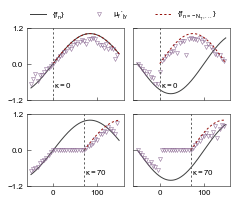

In [8]:
gs = gridspec.GridSpec(2, 2,
                       left=0.15, right=0.985, 
                       top=0.9, bottom=0.1, 
                       wspace=0.1, hspace=0.2)

fig2 = plt.figure(figsize=(cm2inch(8.6),cm2inch(7)))

for idx_freq in xrange(2): # loops over perfect and imperfect learning
    
    ax=0 # Depicts end of Measurement Record + Prediction Horizon
#     ax_begin=0 # Depicts training Data at Begining of Measurement Record
    
    for idx_cases in xrange(2): # loops over constraints on periodicity

        ax = fig2.add_subplot(gs[idx_cases, idx_freq])
        
#         ax_begin = fig.add_subplot(gs[idx_cases, 1 + idx_freq*2]
#         if idx_cases==0:
#                 ax.text(.1,1.3,FLABELS[idx_freq],horizontalalignment='left',transform=ax.transAxes, fontsize=Fsize)

            
        pred_list=[]

        # Get data
        X, Y, TestX, truth, msmts = simple_unlearnable_sine(nt=n_train, delta_t = Delta_T, f0 = F_CASE[idx_freq], 
                                                            testpts=n_predict, randomise='y')

        # set model
        kernel_per = GPy.kern.StdPeriodic(1, period=period_0, variance=sigma_0, 
                                          lengthscale=length_scale_0)
        gauss = GPy.likelihoods.Gaussian(variance=R_0)
        exact = GPy.inference.latent_function_inference.ExactGaussianInference()
        m1 = GPy.core.GP(X=X, Y=Y, kernel=kernel_per, likelihood=gauss, inference_method=exact)

        # constrain periodicty if required
        if idx_cases !=0:
            m1.std_periodic.period.constrain_bounded(CASES_min[idx_cases], CASES_max[idx_cases])

        print("Periodicity is: ", m1.std_periodic.period)
        print("Kernel Basis Spacing is: ", 1. / m1.std_periodic.period)
        print(" True Frequency / Kernel Basis Spacing  is: ", (F_CASE[idx_freq]/3.)*m1.std_periodic.period)

        # take predictions
        pred_list.append(m1.predict(TestX)[0].flatten())
        
        # plot the truth n > 0
        ax.plot(range(-n_testbefore, n_predict, 1), truth[n_train - n_testbefore : ], 
            '-', color=COLOURDICT['TRUTH'], lw=1.0, #markersize=1, 
            label=r'$ \{f_n \}$' )
        
        # plot predictions n > 0
        ax.plot(range(-n_testbefore, n_predict, 5), pred_list[0][::5], # thin out by plotting every 5th msmt
                'v', markerfacecolor='None', markersize=4, markeredgecolor= FCOLOR[idx_cases], markeredgewidth=0.5,
                label=r'$\mu_{f^*|y}$', alpha=1.)
        # plot the truth n = 0
        ax.plot(range(-offset[idx_cases], n_predict, 1), truth[0:n_predict + offset[idx_cases]], 
                      ':', color=COLOURDICT['GPRP2'], lw=1.0,#markersize=1, 
                      label=r'$ \{f_{n= -N_T,...} \} $' ) # offset is annoyingly a negative value.
        
        ax.axvline(x=CONSTRAINT[idx_cases], ls=':', lw=1.0, 
                   color=COLOURDICT['DATA'])
        ax.text(CONSTRAINT[idx_cases] + 2, -0.8, r'$\kappa = $%s'%(np.round(CONSTRAINT[idx_cases])))

#         if idx_freq==0 and idx_cases==1:
#             ax.set(xlabel='Time Steps [num] ' "\n" r'$\kappa \equiv \frac{2 \pi}{\Delta t\omega_0} - N_T$')

#         if idx_cases==0 and idx_freq==0:
#             ax.set(ylabel=r'Predictions [$\hat{f}_n$]')
            

        
        # Formatting
        if idx_cases ==0: # top row
            ax.set(xticklabels=[])
        if idx_freq ==1: # second column
            ax.set(yticklabels=[])
        ax.set_ylim([-1.2, 1.2])
        ax.tick_params(direction='in', which='both')
        ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
        #ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=3))
        ax = set_font_sizes(ax, fsize, Fsize)
        if idx_freq==0 and idx_cases==0:
            ax.legend(loc=3,  fontsize=fsize, frameon=False, bbox_to_anchor=(0., 1.02, 2., .102), 
                     ncol=3, mode="expand", borderaxespad=0.)
            #ax.legend(loc=0, frameon=False)

    
fig2.savefig(savefig2+figname2+'.svg', format='svg', dpi=my_dpi)
plt.show()
plt.close()